In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

# Load the dataset with the specified file path
file_path = r"C:\Users\souri\Downloads\Time_mean_Sea_Level_Projections_to_2300_1256196317263358205.csv"

# Read the dataset
df = pd.read_csv(file_path)  # This line was missing in your code

# Display dataset summary instead of full print to avoid IOPub data rate errors
print(df.info())  # Shows dataset structure, including column names and data types
print(df.head(10))  # Displays the first 10 rows for a quick preview


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6975 entries, 0 to 6974
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OBJECTID            6975 non-null   int64  
 1   Y                   6975 non-null   float64
 2   X                   6975 non-null   float64
 3   RCP and Percentile  6975 non-null   object 
 4   2010 seaLevelAnom   6975 non-null   float64
 5   2020 seaLevelAnom   6975 non-null   float64
 6   2030 seaLevelAnom   6975 non-null   float64
 7   2040 seaLevelAnom   6975 non-null   float64
 8   2050 seaLevelAnom   6975 non-null   float64
 9   2060 seaLevelAnom   6975 non-null   float64
 10  2070 seaLevelAnom   6975 non-null   float64
 11  2080 seaLevelAnom   6975 non-null   float64
 12  2090 seaLevelAnom   6975 non-null   float64
 13  2100 seaLevelAnom   6975 non-null   float64
 14  2110 seaLevelAnom   6975 non-null   float64
 15  2120 seaLevelAnom   6975 non-null   float64
 16  2130 s

In [5]:
# Check structure and missing values
print(df.info())
print(df.describe())
print(df.isnull().sum())  # Should be 0 based on sample

# Unique RCP and percentile values
print(df['RCP and Percentile'].unique())  # e.g., ['rcp26_5', 'rcp26_50', 'rcp26_95', ...]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6975 entries, 0 to 6974
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OBJECTID            6975 non-null   int64  
 1   Y                   6975 non-null   float64
 2   X                   6975 non-null   float64
 3   RCP and Percentile  6975 non-null   object 
 4   2010 seaLevelAnom   6975 non-null   float64
 5   2020 seaLevelAnom   6975 non-null   float64
 6   2030 seaLevelAnom   6975 non-null   float64
 7   2040 seaLevelAnom   6975 non-null   float64
 8   2050 seaLevelAnom   6975 non-null   float64
 9   2060 seaLevelAnom   6975 non-null   float64
 10  2070 seaLevelAnom   6975 non-null   float64
 11  2080 seaLevelAnom   6975 non-null   float64
 12  2090 seaLevelAnom   6975 non-null   float64
 13  2100 seaLevelAnom   6975 non-null   float64
 14  2110 seaLevelAnom   6975 non-null   float64
 15  2120 seaLevelAnom   6975 non-null   float64
 16  2130 s

In [6]:
# Filter UK coordinates
uk_df = df[(df['Y'].between(50, 59)) & (df['X'].between(-11, 2))].copy()

# Split 'RCP and Percentile'
uk_df[['RCP', 'Percentile']] = uk_df['RCP and Percentile'].str.split('_', expand=True)
uk_df.drop('RCP and Percentile', axis=1, inplace=True)

# Melt yearly data into long format
year_cols = [col for col in uk_df.columns if 'seaLevelAnom' in col]
df_long = uk_df.melt(id_vars=['OBJECTID', 'Y', 'X', 'RCP', 'Percentile'], 
                     value_vars=year_cols, 
                     var_name='Year', 
                     value_name='SeaLevelAnom')
df_long['Year'] = df_long['Year'].str.extract(r'(\d+)').astype(int)
print(df_long.head())

   OBJECTID          Y          X    RCP Percentile  Year  SeaLevelAnom
0         1  52.277775 -10.583334  rcp26          5  2010      1.552574
1         2  52.277775 -10.583334  rcp26         50  2010      5.583522
2         3  52.277775 -10.583334  rcp26         95  2010     10.568096
3         4  52.277775 -10.583334  rcp45          5  2010      1.464801
4         5  52.277775 -10.583334  rcp45         50  2010      5.632178


In [7]:
# Average sea level rise by RCP and year
avg_by_rcp = df_long.groupby(['RCP', 'Year'])['SeaLevelAnom'].mean().reset_index()

# Max rise by location in 2300
max_2300 = uk_df[['Y', 'X', '2300 seaLevelAnom']].sort_values('2300 seaLevelAnom', ascending=False).head()
print("Top 5 locations with highest sea level rise by 2300:")
print(max_2300)

# Flag high-risk areas (>100 cm by 2300)
uk_df['HighRisk_2300'] = uk_df['2300 seaLevelAnom'] > 100
high_risk = uk_df[uk_df['HighRisk_2300']][['Y', 'X', 'RCP', 'Percentile', '2300 seaLevelAnom']]
print("High-risk areas by RCP:")
print(high_risk.groupby('RCP').size())

Top 5 locations with highest sea level rise by 2300:
              Y         X  2300 seaLevelAnom
2681  50.055553 -5.750000          441.69403
2987  50.055553 -5.416667          441.13498
2672  50.166664 -5.750000          440.51660
3302  50.055553 -5.083334          440.47240
3464  50.055553 -4.916667          440.07983
High-risk areas by RCP:
RCP
rcp26     919
rcp45    1215
rcp85    1812
dtype: int64


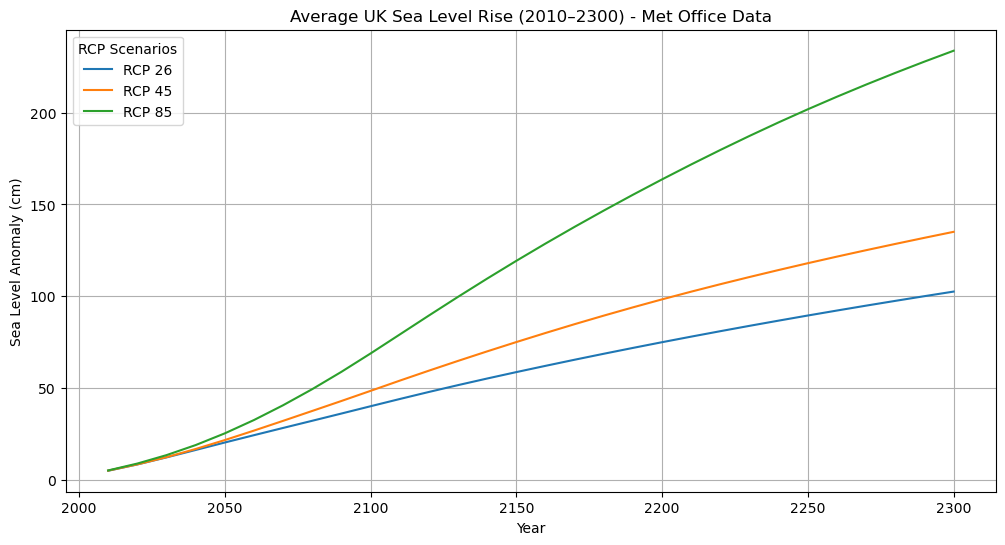

In [8]:
plt.figure(figsize=(12, 6))
for rcp in avg_by_rcp['RCP'].unique():
    subset = avg_by_rcp[avg_by_rcp['RCP'] == rcp]
    plt.plot(subset['Year'], subset['SeaLevelAnom'], label=f'RCP {rcp[3:]}')
plt.title('Average UK Sea Level Rise (2010–2300) - Met Office Data')
plt.xlabel('Year')
plt.ylabel('Sea Level Anomaly (cm)')
plt.legend(title='RCP Scenarios')
plt.grid(True)
plt.savefig(r"C:\Users\souri\Downloads\sea_level_trends.png", dpi=300)  # Save to Downloads
plt.show()

In [9]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(uk_df, geometry=gpd.points_from_xy(uk_df['X'], uk_df['Y']), crs="EPSG:4326")

# Interactive Folium map for 2300
m = folium.Map(location=[52.5, -2], zoom_start=6)  # Center on UK
for idx, row in gdf.iterrows():
    color = 'red' if row['2300 seaLevelAnom'] > 100 else 'blue'
    folium.CircleMarker(
        location=[row['Y'], row['X']],
        radius=5,
        popup=f"RCP: {row['RCP']}_{row['Percentile']}\nSea Level Rise (2300): {row['2300 seaLevelAnom']:.1f} cm",
        color=color,
        fill=True,
        fill_color=color
    ).add_to(m)
m.save(r"C:\Users\souri\Downloads\uk_searise_2300.html")  # Save to Downloads
print("Interactive map saved as 'uk_searise_2300.html' in Downloads")

Interactive map saved as 'uk_searise_2300.html' in Downloads


In [10]:
# Percentage of locations at risk (>100 cm) by RCP
risk_summary = uk_df.groupby('RCP')['HighRisk_2300'].mean() * 100
print("Percentage of locations at risk (>100 cm) by RCP:")
print(risk_summary)

# Max sea level rise by 2300
max_rise = uk_df.groupby('RCP')['2300 seaLevelAnom'].max()
print("Maximum sea level rise by 2300 (cm) by RCP:")
print(max_rise)

Percentage of locations at risk (>100 cm) by RCP:
RCP
rcp26    41.963470
rcp45    55.479452
rcp85    82.739726
Name: HighRisk_2300, dtype: float64
Maximum sea level rise by 2300 (cm) by RCP:
RCP
rcp26    234.17279
rcp45    279.55365
rcp85    441.69403
Name: 2300 seaLevelAnom, dtype: float64


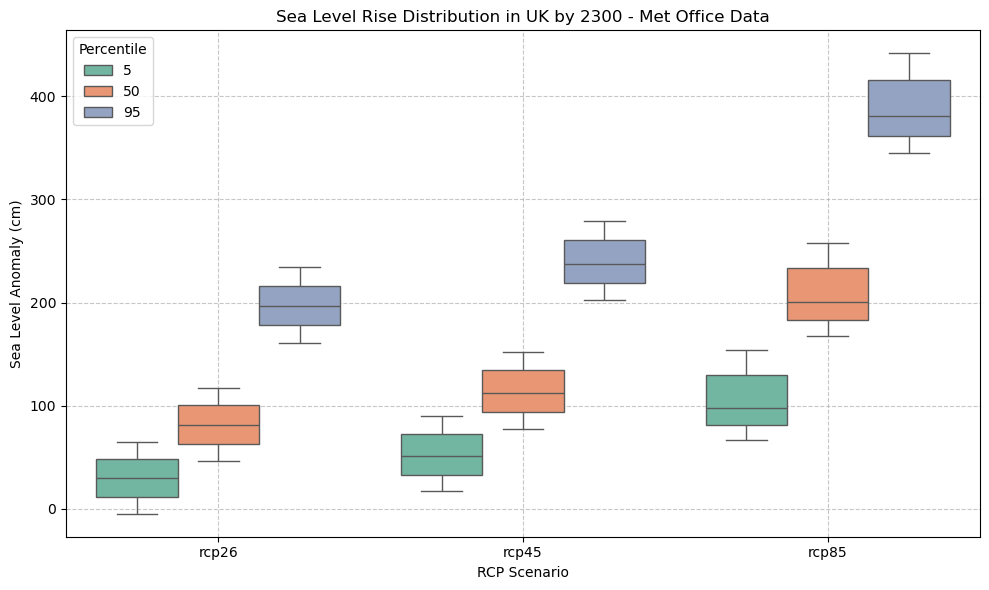

Box plot saved as 'sea_level_boxplot_2300.png' in Downloads


In [11]:
# After Step 5 (Time-Series Visualization) in your existing code

# Create a box plot for 2300 sea level anomalies by RCP
plt.figure(figsize=(10, 6))
sns.boxplot(x='RCP', y='2300 seaLevelAnom', hue='Percentile', data=uk_df, palette='Set2')
plt.title('Sea Level Rise Distribution in UK by 2300 - Met Office Data')
plt.xlabel('RCP Scenario')
plt.ylabel('Sea Level Anomaly (cm)')
plt.legend(title='Percentile')
plt.grid(True, linestyle='--', alpha=0.7)

# Optimize and save
plt.tight_layout()  # Adjusts layout for better spacing
plt.savefig(r"C:\Users\souri\Downloads\sea_level_boxplot_2300.png", dpi=300)
plt.show()
print("Box plot saved as 'sea_level_boxplot_2300.png' in Downloads")